# Permケース

In [15]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import sklearn.linear_model as lm
from scipy.optimize import curve_fit

%matplotlib inline

# Grid
* NX=160, NY=269 (=43,040)
* 1grid =50m
* 8000m, 13450m
* 26246ft, 44127 ft

In [16]:
NX=160
NY=269
Xmeter=NX*50
Ymeter=NY*50
Xfeet=NX*50*3.28084
Yfeet=NY*50*3.28084
print (Xmeter, Ymeter, Xfeet, Yfeet)

8000 13450 26246.72 44127.298


![](1.PNG)
![](2.PNG)

In [17]:
def ReadCore(well):
    core = pd.read_excel('excel-data\Routine Core Data06.xls', well)
    core_select = core.iloc[6:,0:10]
    core_select.columns=['Sample', 'Top', '-', 'Bottom', 'KtoAir_H', 'KtoAir_V', 'Poro', 'So','Sw', 'GrainDensity']
    core_select['Well']=well

    return core_select

CORE = pd.concat([ReadCore('J1'), ReadCore('J2'), ReadCore('J3'), ReadCore('J5'), ReadCore('J7')])


def func(row):
    WELL = row['Well']; TOP = row['Top']; BOT = row['Bottom'];
    
    if   (WELL=='J1') & (TOP>=8243) & (BOT<=8257):
        return 'D'
    elif (WELL=='J1') & (TOP>=8265) & (BOT<=8273):
        return 'E'
    elif (WELL=='J2') & (TOP>=8759) & (BOT<=8773):
        return 'D'
    elif (WELL=='J2') & (TOP>=8779-1.0) & (BOT<=8787):
        return 'E'
    elif (WELL=='J3') & (TOP>=9052) & (BOT<=9070+0.5):
        return 'D'
    elif (WELL=='J3') & (TOP>=9076-0.5) & (BOT<=9086+0.5):
        return 'E'
    elif (WELL=='J5') & (TOP>=8940-0.5) & (BOT<=8960+0.5):
        return 'D'
    elif (WELL=='J5') & (TOP>=8960) & (BOT<=8970+0.5):
        return 'E'
    elif (WELL=='J7') & (TOP>=9057-0.5) & (BOT<=9074+0.5):
        return 'D'
    elif (WELL=='J7') & (TOP>=9081-0.5) & (BOT<=9089+0.5):
        return 'E'
    else:
        return 'other'


CORE['Layer'] = CORE.apply(func, axis=1);
#CORE[CORE.KtoAir_H.str.contains('<')==1].head(3)
CORE['KtoAir_H']=pd.to_numeric(CORE['KtoAir_H'], errors='coerce')
CORE['KtoAir_V']=pd.to_numeric(CORE['KtoAir_V'], errors='coerce')
CORE['Poro']=pd.to_numeric(CORE['Poro'], errors='coerce')
CORE=CORE.reset_index(drop=True)
CORE[(CORE.Layer=='E') & (CORE.Well=='J2')].dropna()

,Sample,Top,-,Bottom,KtoAir_H,KtoAir_V,Poro,So,Sw,GrainDensity,Well,Layer
62,25,8778,-,8779.0,0.21,0.14,0.2,0,7.7,2.89,J2,E
64,26,8780,-,8781.0,210.00,189.00,23.5,14.6,14.2,2.69,J2,E
66,27,8782,-,8783.0,2520.00,1435.00,31.5,18.6,17.3,2.72,J2,E
67,28,8783,-,8784.0,1687.00,1211.00,30.1,14.2,18.4,2.74,J2,E
69,29,8785,-,8786.0,0.28,0.14,1.2,7.9,4.9,2.79,J2,E
70,30,8786,-,8787.0,0.28,0.07,0.9,2.8,5.8,2.82,J2,E


In [4]:
CORE.to_csv(r'excel-data\coreall.txt', index=False)

# Poro-Perm

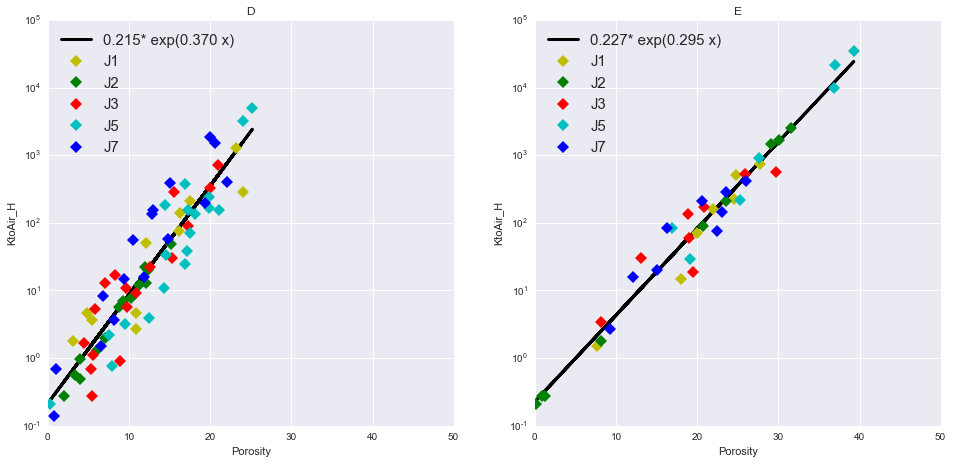

In [108]:
def graph(Layer, num):
    plt.subplot(num)
    plt.xlim(0,50)
    plt.ylim(0.1,100000)
    plt.grid("on")
    plt.xlabel('Porosity')
    plt.ylabel('KtoAir_H')
    plt.title(Layer)
    plt.yscale('log')
        
    x=CORE.Poro[(CORE.Layer== Layer) & (CORE.Poro) & (CORE.KtoAir_H)]
    y=CORE.KtoAir_H[(CORE.Layer== Layer) & (CORE.Poro) & (CORE.KtoAir_H)]
    l= np.log(y)
    lr = lm.LinearRegression()
    lr.fit(x[:,np.newaxis],l)
    l_lr = lr.predict(x[:,np.newaxis])
    a = lr.coef_
    b = lr.intercept_
    r2 = lr.score(x[:,np.newaxis],l)   
    plt.plot(x, np.exp(l_lr), '-k',label='%.3f* exp(%.3f x)' % (np.exp(b), a), linewidth=3)            
    
    

    for well, color in [('J1', 'Dy'), ('J2', 'Dg'), ('J3', 'Dr'), ('J5', 'Dc'), ('J7', 'Db')]:
        xwell=CORE.Poro[(CORE.Well==well) & (CORE.Layer== Layer)]
        ywell=CORE.KtoAir_H[(CORE.Well==well) & (CORE.Layer== Layer)]
        plt.plot(xwell, ywell, color, label=well, ms=9)

    plt.legend(loc=2,prop={'size':15})
    
plt.figure(figsize=(16,16))
for a, b in [('D', 221), ('E', 222)]:
    graph(a, b)    

# KvKh

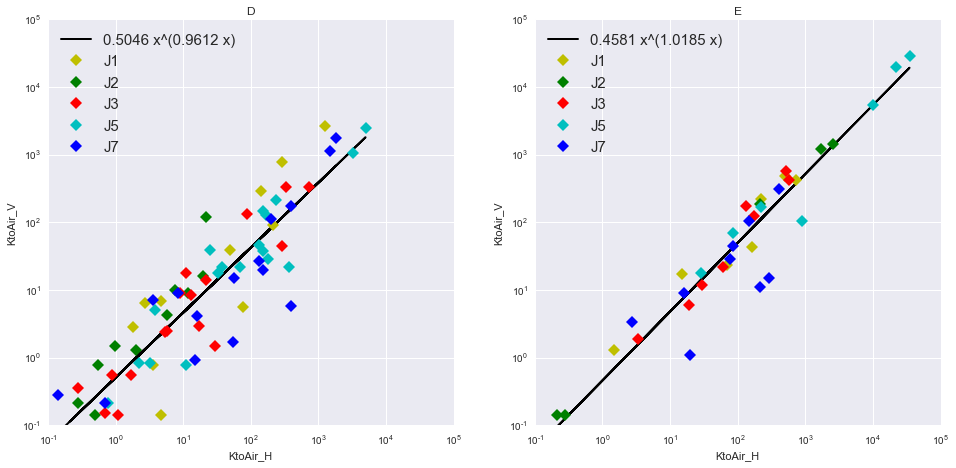

In [109]:
def graph(Layer, num):
    plt.subplot(num)
    plt.xlim(0.1,100000)
    plt.ylim(0.1,100000)
    plt.grid("on")
    plt.xlabel('KtoAir_H')
    plt.ylabel('KtoAir_V')
    plt.title(Layer)
    plt.yscale('log')
    plt.xscale('log')

    x=CORE.KtoAir_H[(CORE.Layer== Layer) & (CORE.KtoAir_H) & (CORE.KtoAir_V)]
    y=CORE.KtoAir_V[(CORE.Layer== Layer) & (CORE.KtoAir_H) & (CORE.KtoAir_V)]
    lx= np.log(x)
    l= np.log(y)
    lr = lm.LinearRegression()
    lr.fit(lx[:,np.newaxis],l)
    l_lr = lr.predict(lx[:,np.newaxis])
    a = lr.coef_
    b = lr.intercept_
    r2 = lr.score(lx[:,np.newaxis],l)   

    plt.plot(np.exp(lx), np.exp(l_lr), '-k',label='%.4f x^(%.4f x)' % (np.exp(b), a), linewidth=2)          
        
    for well, color in [('J1', 'Dy'), ('J2', 'Dg'), ('J3', 'Dr'), ('J5', 'Dc'), ('J7', 'Db')]:
        xwell=CORE.KtoAir_H[(CORE.Well==well) & (CORE.Layer== Layer)]
        ywell=CORE.KtoAir_V[(CORE.Well==well) & (CORE.Layer== Layer)]
        plt.plot(xwell, ywell, color, label=well, ms=9)       


    plt.legend(loc=2,prop={'size':15})
    
plt.figure(figsize=(16,16))
for a, b in [('D', 221), ('E', 222)]:
    graph(a, b)

In [ ]:
def graph(Layer, num):
    plt.subplot(num)
    plt.xlim(-1,12)
    plt.ylim(-2,12)
    plt.grid("on")
    plt.xlabel('KtoAir_H')
    plt.ylabel('KtoAir_V')
    plt.title(Layer)
    #plt.yscale('log')
    for well, color in [('J1', 'Dy'), ('J2', 'Dg'), ('J3', 'Dr'), ('J5', 'Dc'), ('J7', 'Db')]:
        xwell=CORE.KtoAir_H[(CORE.Well==well) & (CORE.Layer== Layer)]
        ywell=CORE.KtoAir_V[(CORE.Well==well) & (CORE.Layer== Layer)]
        lxwell =np.log(xwell)
        lywell =np.log(ywell)
        plt.plot(lxwell, lywell, color, label=well, ms=9)       


    x=CORE.KtoAir_H[(CORE.Layer== Layer) & (CORE.KtoAir_H) & (CORE.KtoAir_V)]
    y=CORE.KtoAir_V[(CORE.Layer== Layer) & (CORE.KtoAir_H) & (CORE.KtoAir_V)]
    lx= np.log(x)
    l= np.log(y)
    lr = lm.LinearRegression()
    lr.fit(lx[:,np.newaxis],l)
    l_lr = lr.predict(lx[:,np.newaxis])
    a = lr.coef_
    b = lr.intercept_
    r2 = lr.score(lx[:,np.newaxis],l)   

    plt.plot(lx, l_lr, '--k',label='%.4f x^(%.4f x)' % (np.exp(b), a), linewidth=2)          
    plt.legend(loc=4,prop={'size':15})
    
plt.figure(figsize=(17,17))
for a, b in [('D', 221), ('E', 222)]:
    graph(a, b)